In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
from log_parser import process_file


### parameters

In [3]:
_fname = "../replays/local.log"
_time_step = 100
_symbols = ["PEARLS", "BANANAS"]
_products = ["PEARLS", "BANANAS"]


### pre processing

In [4]:
# load data from file

obj = process_file(_fname)
df = pd.DataFrame(obj)

listings = pd.DataFrame(df["listings"][0])
df = df.drop("listings", axis=1)
df = df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

Reading from input file ../replays/local.log


In [5]:
# add turns (vs time)

all_times = df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
df["turn"] = df["time"].map(time2turn_map)

df.index = df["turn"]

In [6]:
def process_book(book):
    best_buy = {}
    best_sell = {}
    ret = {}
    cols = ["price", "quantity"]
    for sym in _symbols:
        orders = {
            "buy": pd.DataFrame(columns=cols),
            "sell": pd.DataFrame(columns=cols),
        }
        
        if sym in book:
            if "buy_orders" in book[sym]:
                orders["buy"] = pd.DataFrame(book[sym]["buy_orders"].items(), columns=cols).sort_values(by="price", ascending=False)
            if "sell_orders" in book[sym]:
                orders["sell"] = pd.DataFrame(book[sym]["sell_orders"].items(), columns=cols).sort_values(by="price", ascending=True)
        
        ret[sym] = orders
        
        if len(orders["buy"]) > 0:
            best_buy[sym] = orders["buy"]["price"][0]
        else:
            best_buy[sym] = np.nan
            
        if len(orders["sell"]) > 0:
            best_sell[sym] = orders["sell"]["price"][0]
        else:
            best_sell[sym] = np.nan
            
        
    return ret, best_buy, best_sell


books = pd.DataFrame(df["book"].apply(process_book).to_list(), columns=["book", "best_buy", "best_sell"])
book_tops = books.drop("book", axis=1)

# all book tops
book_tops = pd.concat([book_tops[c].apply(pd.Series).add_suffix(f"_{c}") for c in book_tops.columns], axis=1).astype(int)

for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)


# all books
books = books["book"]

In [7]:
num_data = len(book_tops.dropna())
num_data_dropna = len(book_tops)

print(f"Orig count: {num_data}")
print(f"dropna count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 2000
dropna count: 2000
nan count: 0


In [8]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_action"] = np.where(df["buyer"] == "SUBMISSION", "buy", None)
    df["my_action"] = np.where(df["seller"] == "SUBMISSION", "sell", None)
    df["my_quantity"] = df["quantity"] * df["is_me"].astype(int) * (2 * (df["my_action"] == "buy").astype(int) - 1)
    
    return df

In [9]:
df["own_trades"]

turn
0                           {'BANANAS': [], 'PEARLS': []}
1       {'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...
2       {'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...
3       {'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...
4       {'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...
                              ...                        
1995                        {'BANANAS': [], 'PEARLS': []}
1996                        {'BANANAS': [], 'PEARLS': []}
1997                        {'BANANAS': [], 'PEARLS': []}
1998                        {'BANANAS': [], 'PEARLS': []}
1999                        {'BANANAS': [], 'PEARLS': []}
Name: own_trades, Length: 2000, dtype: object

In [10]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")


# filter market trades (only keep those where order_time = fill_time)
market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] == my_trades["order_time"] + _time_step]


trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


In [11]:
# get my_positions
my_positions = pd.DataFrame(list(df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
cash_data = []
cur_cash = 0
cur_time = turn2time_map[0]
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        cash_data += [cur_cash]
        cur_time = turn2time_map[len(cash_data)]
        
    cur_cash += -1 * row["price"] * row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    cash_data += [cur_cash]
    cur_time = turn2time_map[len(cash_data)]
cash_data += [cur_cash]

# add to my_positions
my_positions["cash"] = cash_data






### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

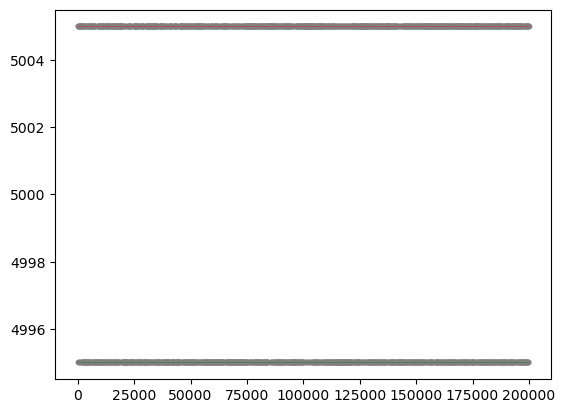

In [12]:
# plot trades

sym = "BANANAS"

plt_df = trade_df[trade_df["symbol"] == sym]

my_buys = plt_df[plt_df["my_quantity"] > 0]
my_sells = plt_df[plt_df["my_quantity"] < 0]
their_trades = plt_df[plt_df["my_quantity"] == 0]

plt.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
plt.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
plt.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)


# plot book
plt.plot(df["time"], book_tops[f"{sym}_best_buy"], c="green", alpha=0.5, linewidth=0.5)
plt.plot(df["time"], book_tops[f"{sym}_best_sell"], c="red", alpha=0.5, linewidth=0.5)

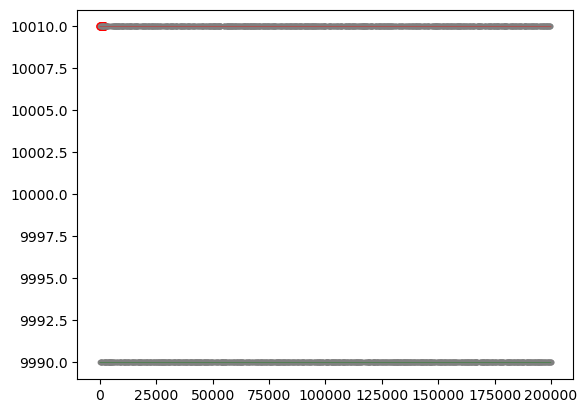

In [13]:
# plot trades

sym = "PEARLS"

plt_df = trade_df[trade_df["symbol"] == sym]

my_buys = plt_df[plt_df["my_quantity"] > 0]
my_sells = plt_df[plt_df["my_quantity"] < 0]
their_trades = plt_df[plt_df["my_quantity"] == 0]

plt.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
plt.scatter(my_sells["time"], my_sells["price"], c="red", s=25)

plt.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)


# plot book
plt.plot(df["time"], book_tops[f"{sym}_best_buy"], c="green", alpha=0.5, linewidth=0.5)
plt.plot(df["time"], book_tops[f"{sym}_best_sell"], c="red", alpha=0.5, linewidth=0.5)

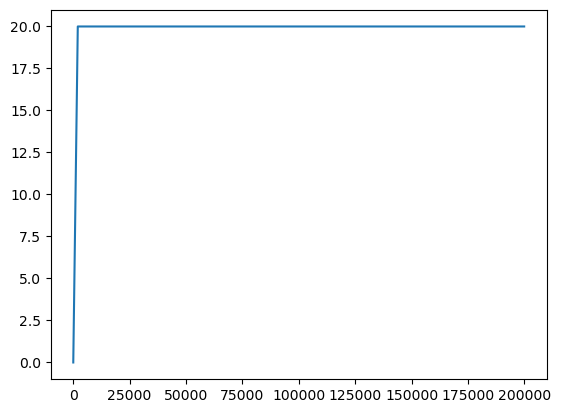

In [14]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"])

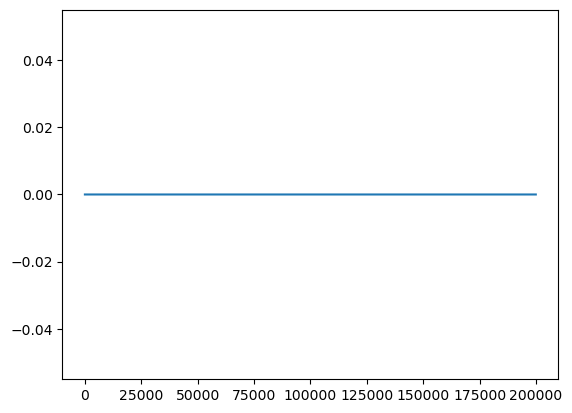

In [15]:
# plot my positions in each product

# plt.bar(my_positions["time"], my_positions["BANANAS"])
plt.plot(my_positions["time"], my_positions["BANANAS"])

In [16]:
my_positions

,BANANAS,PEARLS,time,turn,cash
0,0,0,0,0,0
1,0,1,100,1,10010
2,0,2,200,2,20020
3,0,3,300,3,30030
4,0,4,400,4,40040
...,...,...,...,...,...
1995,0,20,199500,1995,200200
1996,0,20,199600,1996,200200
1997,0,20,199700,1997,200200
1998,0,20,199800,1998,200200


In [17]:
set(i for i in range(0, 200000, 100)) - set(df["time"])

set()

In [18]:
df["book"][0]["BANANAS"]

{'buy_orders': {'4995': 2}, 'sell_orders': {'5005': 2}}

In [19]:
listings

,BANANAS,PEARLS
denomination,1,1
product,BANANAS,PEARLS
symbol,BANANAS,PEARLS


In [20]:
df

,market_trades,observations,book,own_trades,position,time,turn
turn,,,,,,,
0,"{'BANANAS': [], 'PEARLS': []}",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': []}","{'BANANAS': 0, 'PEARLS': 0}",0,0
1,"{'BANANAS': [{'buyer': '', 'price': 5005, 'qua...",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...","{'BANANAS': 0, 'PEARLS': 1}",100,1
2,"{'BANANAS': [{'buyer': '', 'price': 5005, 'qua...",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...","{'BANANAS': 0, 'PEARLS': 2}",200,2
3,"{'BANANAS': [{'buyer': '', 'price': 4995, 'qua...",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...","{'BANANAS': 0, 'PEARLS': 3}",300,3
4,"{'BANANAS': [{'buyer': '', 'price': 5005, 'qua...",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': [{'buyer': 'SUBMISSI...","{'BANANAS': 0, 'PEARLS': 4}",400,4
...,...,...,...,...,...,...,...
1995,"{'BANANAS': [{'buyer': '', 'price': 4995, 'qua...",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': []}","{'BANANAS': 0, 'PEARLS': 20}",199500,1995
1996,"{'BANANAS': [{'buyer': '', 'price': 5005, 'qua...",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': []}","{'BANANAS': 0, 'PEARLS': 20}",199600,1996
1997,"{'BANANAS': [{'buyer': '', 'price': 5005, 'qua...",{},"{'BANANAS': {'buy_orders': {'4995': 2}, 'sell_...","{'BANANAS': [], 'PEARLS': []}","{'BANANAS': 0, 'PEARLS': 20}",199700,1997
